In [1]:
from pathlib import Path

import numpy as np
import cv2
import matplotlib.pyplot as plt
import pandas as pd
import sklearn
from sklearn.neural_network import MLPClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, ConfusionMatrixDisplay
from tqdm.notebook import tqdm
import mediapipe as mp

mp_hands = mp.solutions.hands

In [2]:
data_root = Path('D:\Imam\Belajar\Python\Computer_Vision\Sign-Language-Digits-Datase/')
train_dir = data_root / 'train'
validation_dir = data_root / 'valid'

assert train_dir.exists()
assert validation_dir.exists()

# Load image sample

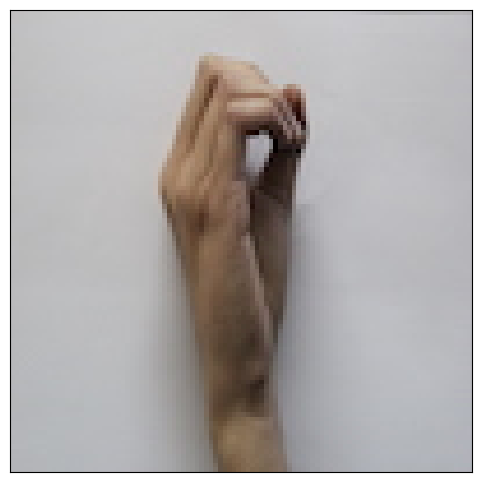

In [3]:
def imread_rgb(x):
    return cv2.imread(str(x))[..., ::-1].astype(np.uint8)
    
sample_file = list((train_dir.glob('*/*')))[9]
sample_img = imread_rgb(sample_file)

fig, ax = plt.subplots(figsize=(6, 6))
ax.imshow(sample_img);
ax.set_yticks([])
ax.set_xticks([]);

# Find and visualize landmark using mediapipe lib

In [4]:
def load_landm(img):
    with mp_hands.Hands(
        static_image_mode=True,
        max_num_hands=2,
        min_detection_confidence=0.5) as hands:

        results = hands.process(img)
    return results

sample_lm = load_landm(sample_img)
sample_lm

mediapipe.python.solution_base.SolutionOutputs

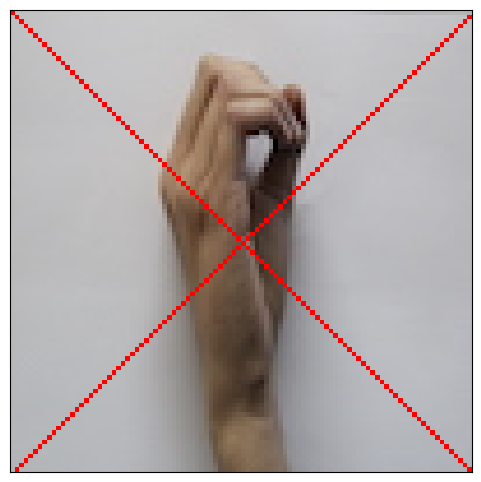

In [5]:
def visulize_lm(lm, img):
    _img = img.copy()
    
    if load_landm(img).multi_hand_landmarks is None:
        cv2.line(_img, [0, 0], [_img.shape[1], _img.shape[0]], color=(255, 0, 0))
        cv2.line(_img, [_img.shape[1], 0], [0, _img.shape[0]], color=(255, 0, 0))
        return _img

    for l in load_landm(img).multi_hand_landmarks[0].landmark:
        x = int(l.x*_img.shape[1])
        y = int(l.y*_img.shape[0])
        v = (l.z * 1500 * -1)
        cv2.circle(_img, (x, y), 1, color=(v, 0, 255-v), thickness=-1)
    
    return _img

img_vis = visulize_lm(sample_lm, sample_img)

fig, ax = plt.subplots(figsize=(6, 6))
ax.imshow(img_vis);
ax.set_yticks([])
ax.set_xticks([]);

# Find landmarks for each sample

In [6]:
def landmark_to_nparray(lm):
    arr = np.empty(shape=[21, 3])
    for i, l in enumerate(lm.multi_hand_landmarks[0].landmark):
        arr[i, :] = [l.x, l.y, l.z]
    return arr
        

def build_datsframe(dir_path):
#     df = pd.DataFrame()

    files = list(dir_path.glob('*/*'))
    labels = list(map(lambda x: int(str(x.parent)[-1]), files))

    files_list = []
    lm_list = []
    lbl_list = []
    is_lm = []

    for f, l in tqdm(zip(files, labels), total=len(files)):
        img = imread_rgb(f)
        lm = load_landm(img)
        if lm.multi_hand_landmarks is None:
            lm_list.append(None)
            lbl_list.append(l)
            files_list.append(files)
            is_lm.append(False)
            continue

        lmarr = landmark_to_nparray(lm)
        lm_list.append(lmarr)
        lbl_list.append(l)
        files_list.append(files)
        is_lm.append(True)
        
    return pd.DataFrame({'file': files, 'label': labels, 'lm': lm_list})
        
train_df = build_datsframe(train_dir)
valid_df = build_datsframe(validation_dir)

  0%|          | 0/1712 [00:00<?, ?it/s]

  0%|          | 0/300 [00:00<?, ?it/s]

In [7]:
train_df.sample(5)

,file,label,lm
376,D:\Imam\Belajar\Python\Computer_Vision\Sign-La...,2,None
426,D:\Imam\Belajar\Python\Computer_Vision\Sign-La...,2,None
1119,D:\Imam\Belajar\Python\Computer_Vision\Sign-La...,6,"[[0.5152004957199097, 0.902681291103363, 1.201..."
1310,D:\Imam\Belajar\Python\Computer_Vision\Sign-La...,7,"[[0.3872789442539215, 0.7639576196670532, 1.18..."
1472,D:\Imam\Belajar\Python\Computer_Vision\Sign-La...,8,None


# Check how many samples have been discarded

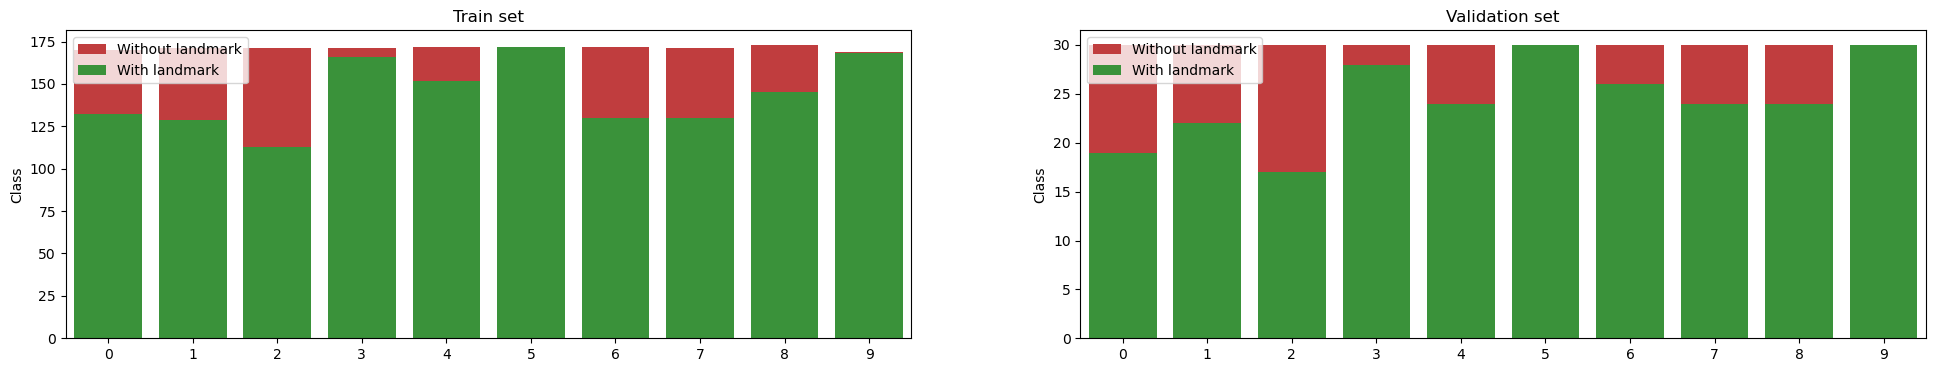

In [8]:
train_file_count = train_df.groupby('label').count().file
train_lm_count = train_df.groupby('label').count().lm

valid_file_count = valid_df.groupby('label').count().file
valid_lm_count = valid_df.groupby('label').count().lm

import seaborn as sns
fig, ax = plt.subplots(figsize=(24, 4), ncols=2)

sns.barplot(x = np.arange(10), y = train_file_count, label='Without landmark', color='tab:red', ax=ax[0])
sns.barplot(x = np.arange(10), y = train_lm_count, label='With landmark', color='tab:green', ax=ax[0])

sns.barplot(x = np.arange(10), y = valid_file_count, label='Without landmark', color='tab:red', ax=ax[1])
sns.barplot(x = np.arange(10), y = valid_lm_count, label='With landmark', color='tab:green', ax=ax[1])

for i in range(2):
    ax[i].set_ylabel('Count')
    ax[i].set_ylabel('Class')
    ax[i].legend()
    
ax[0].set_title('Train set');
ax[1].set_title('Validation set');

# Visualize some landmarks

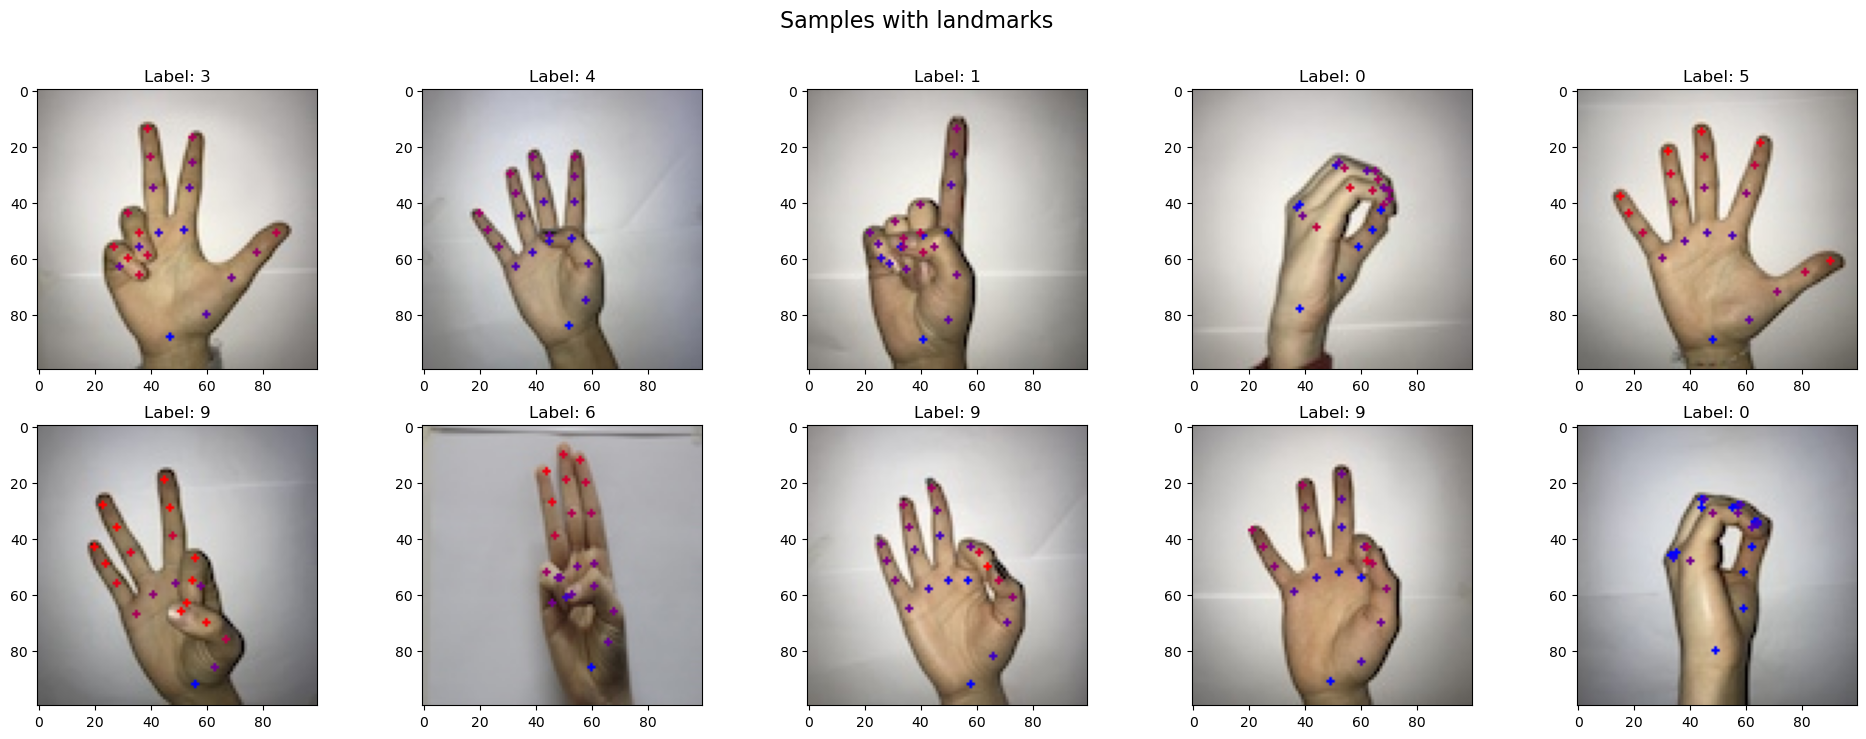

In [9]:
train_df_with_lm = train_df[~pd.isnull(train_df.lm)]

fig, ax = plt.subplots(ncols=5, nrows=2, figsize=[24, 8])
ax = ax.ravel()

for i, (idx, row) in enumerate(train_df_with_lm.sample(10).iterrows()):
    img = imread_rgb(row.file)
    vis = visulize_lm(row.lm, img)
    
    ax[i].imshow(vis)
    ax[i].set_title(f'Label: {row.label}')
    
fig.suptitle('Samples with landmarks', fontsize=16);

# Visualize sampels where mediapipe failed to load landmarks

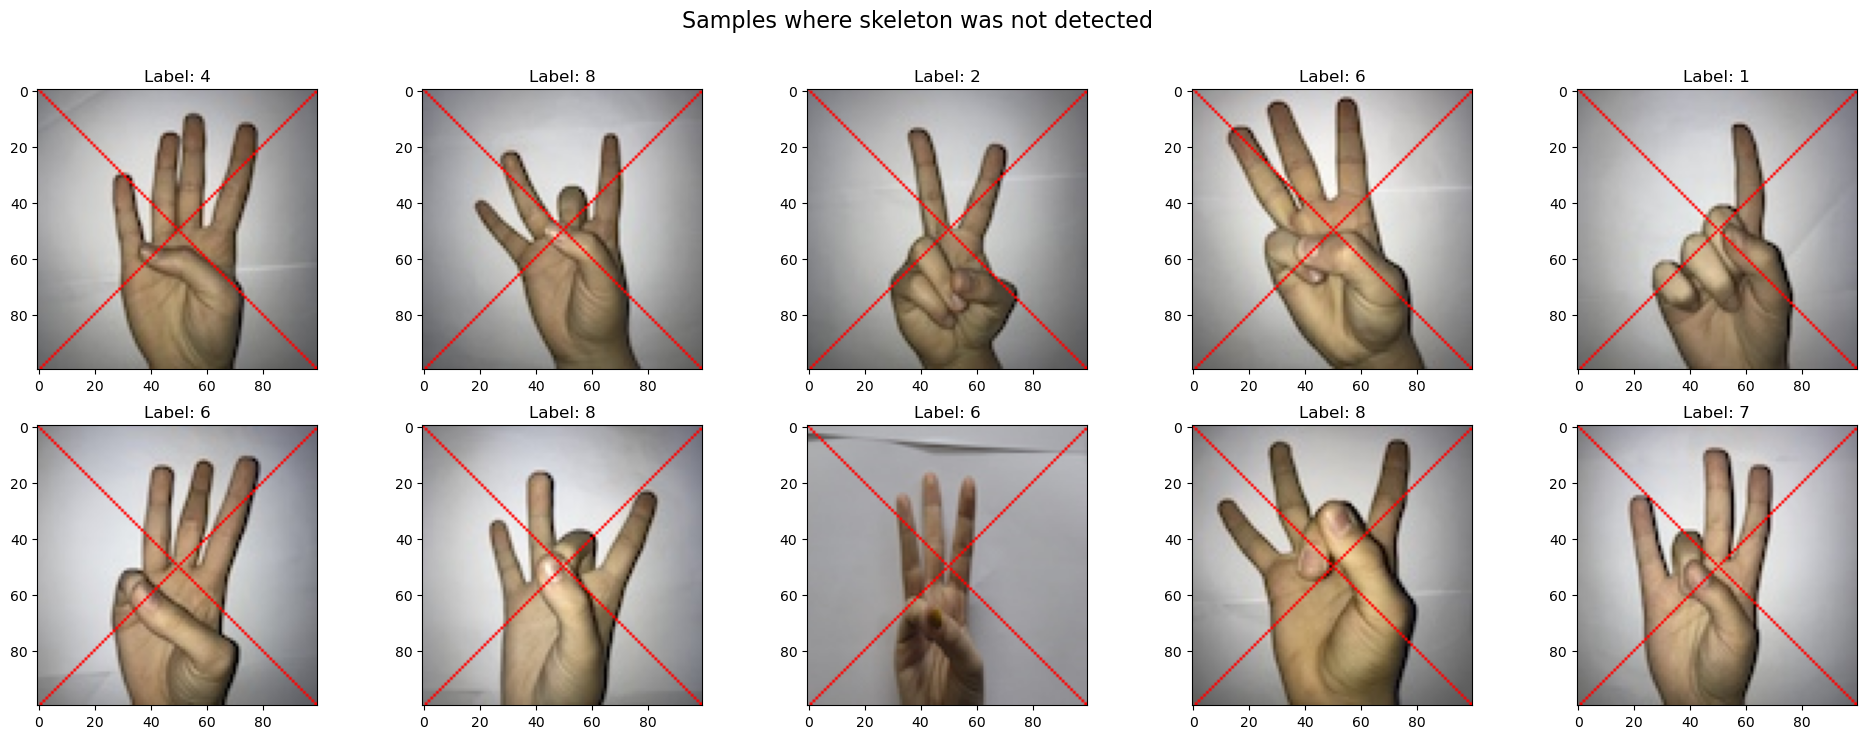

In [10]:
train_df_without_lm = train_df[pd.isnull(train_df.lm)]

fig, ax = plt.subplots(ncols=5, nrows=2, figsize=[24, 8])
ax = ax.ravel()

for i, (idx, row) in enumerate(train_df_without_lm.sample(10).iterrows()):
    img = imread_rgb(row.file)
    vis = visulize_lm(row.lm, img)
    
    ax[i].imshow(vis)
    ax[i].set_title(f'Label: {row.label}')
    
fig.suptitle('Samples where skeleton was not detected', fontsize=16);

# Train model using landmakrs

In [11]:
def load_x_y_from_df(df):
    _df = df[~pd.isnull(df.lm)]
    return np.stack([x for x in _df.lm]), _df.label
#     return _df
    
x_train, y_train = load_x_y_from_df(train_df)
x_valid, y_valid = load_x_y_from_df(valid_df)

In [12]:
def prepare_x(x):
    num_samples, num_features, num_coordinates = x.shape
    x_prepared = x.reshape((num_samples, num_features*num_coordinates))
    return x_prepared


# x_train_augmented = flip_x_coordinate(x_train)
# x_train_augmented = prepare_x(x_train_augmented)
x_train = prepare_x(x_train)
x_valid = prepare_x(x_valid)

# x_train = np.concatenate([x_train ,x_train_augmented], axis=0)
# y_train = np.concatenate([y_train, y_train], axis=0)
x_train.shape, y_train.shape, '\n', x_valid.shape, y_valid.shape

((1437, 63), (1437,), '\n', (244, 63), (244,))

In [13]:
classifier = MLPClassifier(random_state=1, max_iter=500)
classifier.fit(x_train, y_train)

C:\Users\imamj\anaconda3\envs\torch\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(


MLPClassifier(max_iter=500, random_state=1)

In [14]:
pred_train = classifier.predict(x_train)
pred_valid = classifier.predict(x_valid)
val_acc = accuracy_score(pred_valid, y_valid)
train_acc = accuracy_score(pred_train, y_train)

train_df_with_pred = train_df[~pd.isnull(train_df.lm)].copy()
train_df_with_pred['pred'] = pred_train

valid_df_with_pred = valid_df[~pd.isnull(valid_df.lm)].copy()
valid_df_with_pred['pred'] = pred_valid

print(f'Train acc: {train_acc} \t Valid acc: {val_acc}')

Train acc: 0.9979123173277662 	 Valid acc: 0.9918032786885246


# Visualize random predictions from validation set

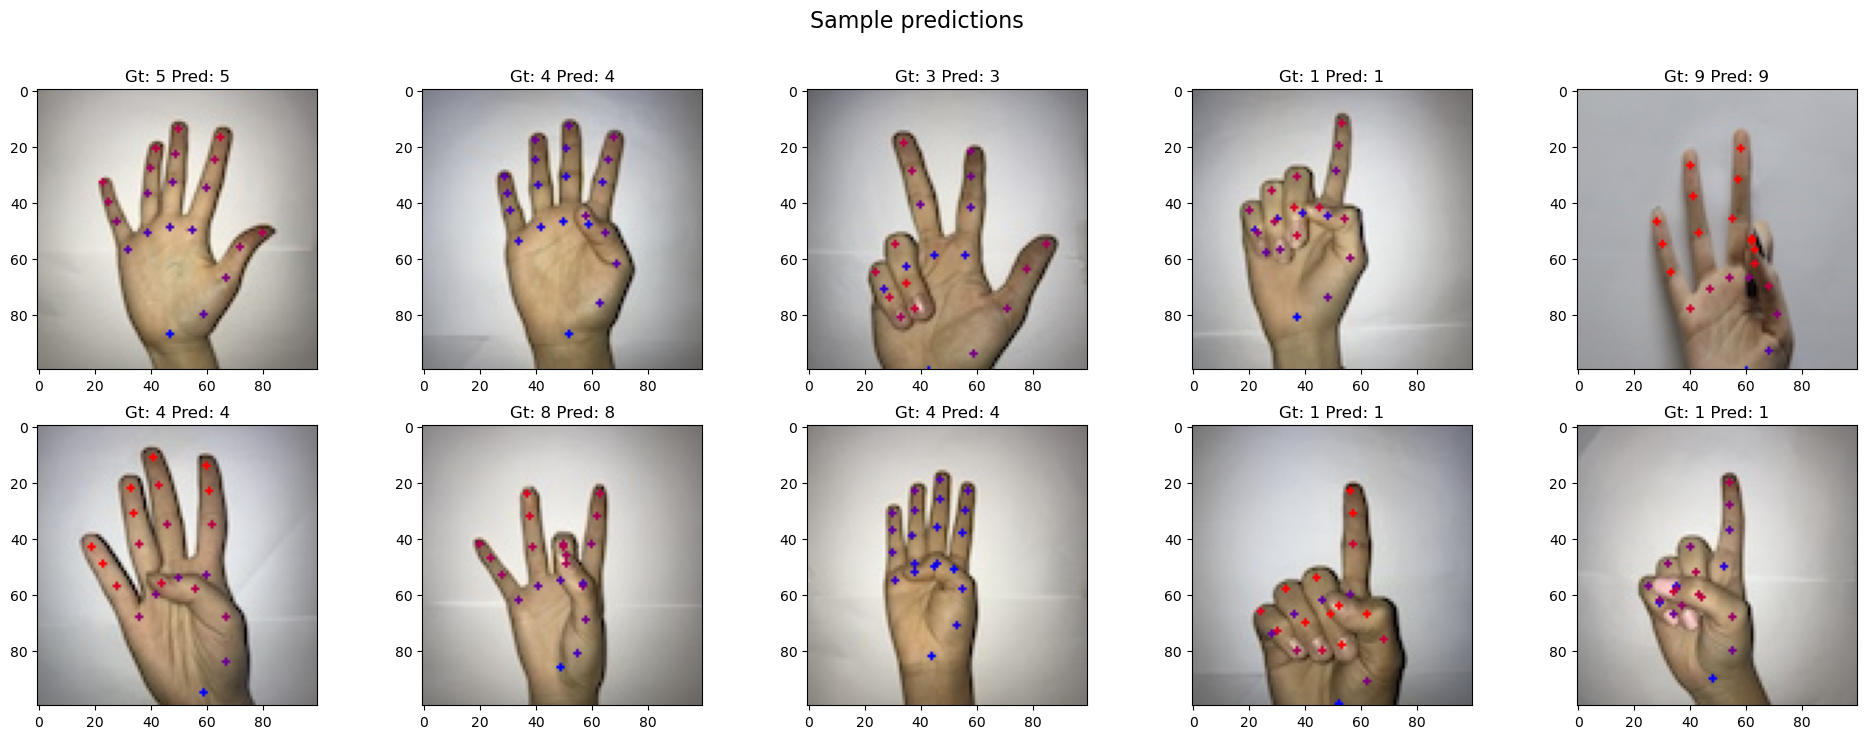

In [15]:
fig, ax = plt.subplots(ncols=5, nrows=2, figsize=[24, 8])
ax = ax.ravel()

for i, (idx, row) in enumerate(valid_df_with_pred.sample(10).iterrows()):
    img = imread_rgb(row.file)
    vis = visulize_lm(row.lm, img)
    
    ax[i].imshow(vis)
    ax[i].set_title(f'Gt: {row.label} Pred: {row.pred}')
    
fig.suptitle('Sample predictions', fontsize=16);

# Only 2 validation samples failed. Visualize them

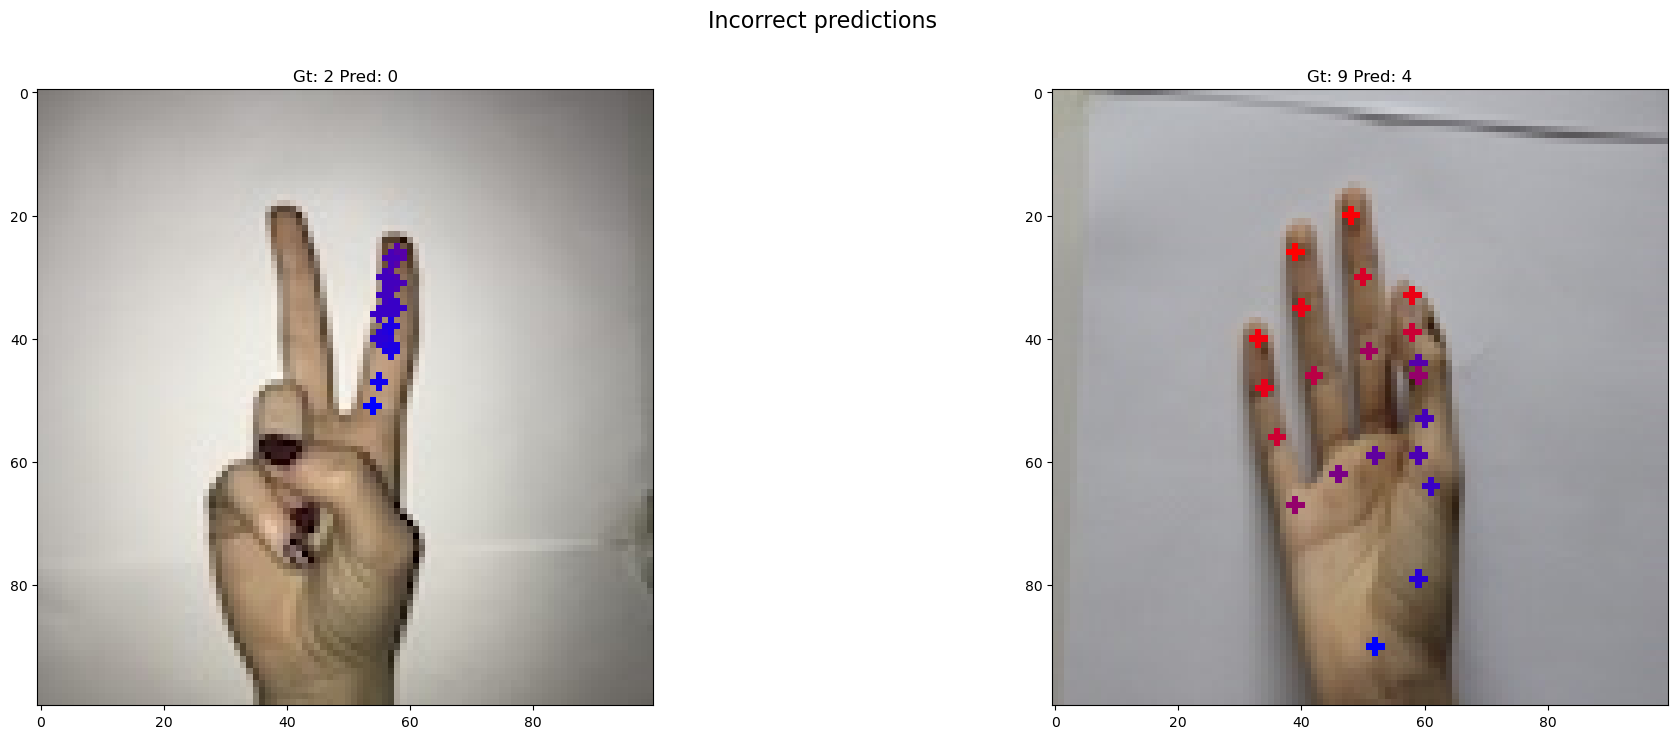

In [16]:

fig, ax = plt.subplots(ncols=2, nrows=1, figsize=[24, 8])
ax = ax.ravel()

valid_df_with_false_pred = valid_df_with_pred[valid_df_with_pred.label != valid_df_with_pred.pred]
for i, (idx, row) in enumerate(valid_df_with_false_pred.sample(2).iterrows()):
    img = imread_rgb(row.file)
    vis = visulize_lm(row.lm, img)
    
    ax[i].imshow(vis)
    ax[i].set_title(f'Gt: {row.label} Pred: {row.pred}')
fig.suptitle('Incorrect predictions', fontsize=16);

# Train confusion matrix

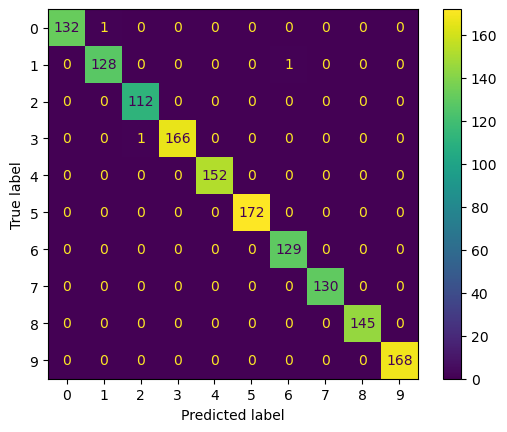

In [17]:
conf_matr = confusion_matrix(pred_train, y_train)
cm_display = ConfusionMatrixDisplay(conf_matr).plot()

# Validation confusion matrix

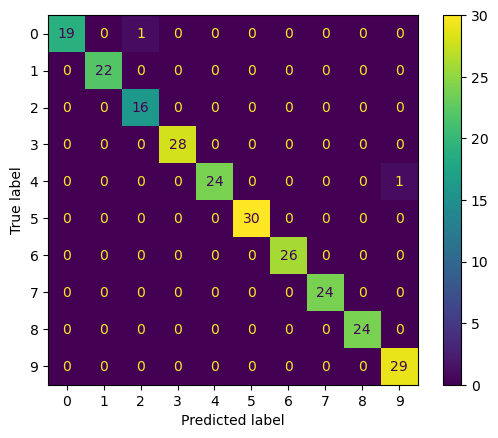

In [18]:
conf_matr = confusion_matrix(pred_valid, y_valid)
cm_display = ConfusionMatrixDisplay(conf_matr).plot()